# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [2]:
data_processed = "../../data/processed/"
data_interim = "../../data/interim/"
data_external = "../../data/external/"

graph_node_data = pd.read_csv(data_processed+"graph_node_table.csv", index_col=0).reset_index(drop=True).astype({"node_name":"string"})
graph_edge_data = pd.read_csv(data_processed+"graph_edge_table.csv", index_col=0).reset_index(drop=True).rename(columns={"relation":"edge_type"}).astype({"edge_idx":"int64"})

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts())
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

/tmp/ipykernel_41457/1636334240.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  graph_edge_data = pd.read_csv(data_processed+"graph_edge_table.csv", index_col=0).reset_index(drop=True).rename(columns={"relation":"edge_type"}).astype({"edge_idx":"int64"})


,Número de nodos
disease,18548
gene/protein,16672
protein_complex,422
total,35642


,Número de enlaces
GDA,84038
PPI,150685
forms_complex,1888
parent_child_mondo,30419
total,267030


In [22]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [4]:
def attributes_from_pd(G:nx.Graph,df:pd.DataFrame,attributes:dict,indexcol):
    """Dados un grafo G y un dataframe df con atributos de sus nodos, especificamos los atributos
    que queremos agregar a los nodos en un diccionario con formato {nombre_columna:nombre_atributo}. 
    La función arma un diccionario con los atributos y el nombre que le queremos poner, indexado con el identificador de nodo que elegimos 
    y los asigna a los nodos del grafo"""
    for attribute,name in attributes.items():
        nx.set_node_attributes(G,pd.Series(df.set_index(indexcol)[attribute]).to_dict(),name)

def get_node_dict(G):
    return {node:data for (node,data) in list(G.nodes(data=True))}

In [5]:
edges_enfermedades = graph_edge_data[graph_edge_data.edge_type == "parent_child_mondo"]
nodos_enfermedades = graph_node_data[graph_node_data.node_type == "disease"]
DD = nx.from_pandas_edgelist(edges_enfermedades,source="a_idx",target="b_idx",edge_attr="edge_idx")
DD_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source","disgenet_type":"disgenet_type","diseaseClassMSH":"diseaseClassMSH","diseaseClassNameMSH":"diseaseClassNameMSH"}
attributes_from_pd(DD,graph_node_data,DD_attributes,"node_idx")

# Particiones

In [6]:
def particion_a_diccionario(Red_igraph,particion_igraph):
  particion_dict = {}
  for cluster in range(len(particion_igraph)):
    for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
      particion_dict.update({nodo:cluster})
  return particion_dict

def particiones(G):
    dict = {}
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_infomap  = G_igraph.community_infomap()
    dict_comunidades_infomap = particion_a_diccionario(G_igraph,comunidades_infomap)
    modularidad_infomap = G_igraph.modularity(comunidades_infomap)
    dict['Infomap'] = {'comunidades' : comunidades_infomap, 'diccionario':dict_comunidades_infomap, 'modularidad':modularidad_infomap}

    #LA FUNCIÓN COMMUNITY_MULTILEVEL DE IGRAPH UTILIZA EL ALGORITMO LOUVAIN
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_louvain = G_igraph.community_multilevel()
    dict_comunidades_louvain = particion_a_diccionario(G_igraph,comunidades_louvain)
    modularidad_louvain = G_igraph.modularity(comunidades_louvain)
    dict['Louvain'] = {'comunidades' : comunidades_louvain, 'diccionario':dict_comunidades_louvain, 'modularidad':modularidad_louvain}
    return dict

In [7]:
comunidades_dd = particiones(DD)

col_infomap = pd.Series(comunidades_dd['Infomap']['diccionario'],name="comunidades_infomap")
col_louvain = pd.Series(comunidades_dd['Louvain']['diccionario'],name="comunidades_louvain")

nx.set_node_attributes(DD,comunidades_dd['Infomap']['diccionario'],name="comunidad_infomap")
nx.set_node_attributes(DD,comunidades_dd['Louvain']['diccionario'],name="comunidad_louvain")

graph_node_data = pd.merge(graph_node_data,col_infomap,left_on="node_idx",right_index=True, how="left")
graph_node_data = pd.merge(graph_node_data,col_louvain,left_on="node_idx",right_index=True, how="left")

tamaños_infomap = pd.Series(col_infomap.value_counts(), name="tamaño")
tamaños_louvain = pd.Series(col_louvain.value_counts(), name="tamaño")

# Analisis TF-IDF

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
custom_stopwords = ["disease","syndrome","familial","congenital","disorder","type","association","abnormality"]
stop_words = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

In [9]:
data_external = "../../data/external/"
primekg_data = pd.read_csv(data_external+"primekg_disease_features.csv")
disgenet_data = pd.read_csv(data_external+"disease_mappings_to_attributes.tsv", sep="\t")
my_map = pd.read_csv(data_interim +"mondo_cui_map.csv")

In [10]:
enfermedades = graph_node_data[graph_node_data.node_type == "disease"]
enfermedades = pd.merge(enfermedades, my_map, how="left", left_on="node_id", right_on="CUI")
enfermedades = pd.merge(enfermedades,primekg_data, how="left", left_on="mondo", right_on="mondo_id").drop_duplicates(subset="node_id")
#enfermedades[(enfermedades.mondo_definition.isna()) & (enfermedades.umls_description.isna()) & (enfermedades.orphanet_clinical_description.isna())]
enfermedades = enfermedades.set_index("node_idx",drop=False)

In [11]:
def remove_symbols(data):
    symbols = "!-\"\'#$%&()*+/:;<=>?@[\]^_`{|},~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return data

def doc_to_bow(data):
    bow = []
    for text in data:
        split = text.split()
        for word in split:
            bow.append(word)
    return bow

def filter_stopwords(bow):
    return [word for word in bow if not word in stop_words]

def cluster_as_document(cluster_id,cluster_algorithm,join_titles=True):
    titles = graph_node_data.loc[graph_node_data[cluster_algorithm] == cluster_id, "node_name"].values.astype(str)
    titles = np.char.lower(titles)
    titles = remove_symbols(titles)
    if join_titles:
        document = " ".join(titles)
    else:
        document = titles
    return document

def wordcloud_from_tfidf(df,cluster_id):
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(df.loc[cluster_id])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [12]:
def get_tfidf_df(vectorizer,corpus,ids,df=True):
    X = vectorizer.fit_transform(corpus)
    if df:
        #X = pd.DataFrame(X.toarray(), index=ids, columns=vectorizer.get_feature_names_out())
        X = pd.DataFrame.sparse.from_spmatrix(X, index=ids, columns=vectorizer.get_feature_names_out())
    return X

def tfidf_similarity(vectorizer,corpus,ids,df=True):
    scores = get_tfidf_df(vectorizer,corpus,ids,False)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

In [13]:
def node_as_document(node_idx,join_titles=True):
    data = enfermedades.loc[enfermedades["node_idx"] == node_idx, ["node_name","mondo_definition","umls_description","orphanet_definition"]].values.astype(str)
    data = np.delete(data,np.where(data[0] == "nan"))
    data = np.char.lower(data.astype(str))
    data = remove_symbols(data)
    if join_titles:
        document = " ".join(data)
        document = document + " "
        document = document.replace(". ", " ")
    else:
        document = data
    return document

Estoy viendo como conservar los nombres de cromosomas y eliminar los puntos a la vez. Decidí sacar los ". ", puntos seguidos de espacios.

In [45]:
chromosome_id = enfermedades[enfermedades.node_name.apply(lambda x: "." in str(x))].sample(1)
print(chromosome_id.node_name)
aver = node_as_document(chromosome_id.index[0])
aver

node_idx
32874    chromosome 19q13.11 deletion syndrome
Name: node_name, dtype: string


'chromosome 19q13.11 deletion syndrome the 19q13.11 microdeletion is characterized by several major features including pre and postnatal growth retardation  slender habitus  severe postnatal feeding difficulties  microcephaly  intellectual deficit with speech disturbance  hypospadias and ectodermal dysplasia presented by scalp aplasia  thin and sparse hair  eyebrows and eyelashes  thin and dry skin and dysplasic nails the 19q13.11 microdeletion has characteristics of several major features including pre and postnatal growth retardation  slender habitus  severe postnatal feeding difficulties  microcephaly  intellectual deficit with speech disturbance  hypospadias and ectodermal dysplasia presented by scalp aplasia  thin and sparse hair  eyebrows and eyelashes  thin and dry skin and dysplastic nails to date  the syndrome has been identified in five patients haploinsufficiency of one or more genes in the 19q13.11 region could cause this microdeletion syndrome the 19q13.11 microdeletion is

## Similaridad nodo a nodo

In [24]:
corpus = [node_as_document(node_id) for node_id in enfermedades.node_idx.values]
ids = enfermedades.node_idx.values

vectorizer = TfidfVectorizer(tokenizer = lambda document: document.split() , stop_words=stop_words, ngram_range=(1,1),min_df=3,max_df=0.3)
tfidf_similarity_matrix_extended = tfidf_similarity(vectorizer,corpus,ids)

,12260,34397
12260,1.000000,0.474566
34397,0.474566,1.000000


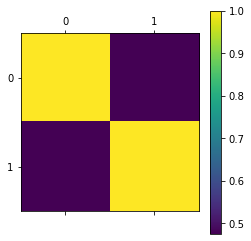

In [15]:
algoritmo = "comunidades_infomap"
cluster = tamaños_infomap.sample(1).index[0]
nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].index.values
plt.matshow(tfidf_similarity_matrix_extended.loc[nodos_cluster,nodos_cluster])
plt.colorbar()

display(tfidf_similarity_matrix_extended.loc[nodos_cluster,nodos_cluster])

In [198]:
enfermedades.sample(1).index[0]

29503

In [262]:
most_similar

14477    1.000000
11695    0.519619
18311    0.457644
15992    0.410923
12630    0.406644
11483    0.406644
12631    0.396635
13573    0.396397
18643    0.394983
16609    0.384950
Name: 14477, dtype: Sparse[float64, 0]

In [269]:
enfermedades.loc[18643,"orphanet_definition"]

'A rare, genetic, motor neuron disease characterized by slowly progressive, predominantly proximal, muscular weakness and atrophy which typically manifests with muscle cramps, fasciculations, decreased/absent deep tendon reflexes, hand tremor, and elevated serum creatine kinase at onset and later associates with reduced walking ability and impaired vibration sensation.'

In [25]:
random_node = enfermedades.sample(1).index[0]
most_similar = tfidf_similarity_matrix_extended[random_node].sort_values(ascending=False)[0:10]
graph_node_data.loc[most_similar.index.values]

,node_idx,node_id,node_type,node_name,node_source,disgenet_type,diseaseClassMSH,diseaseClassNameMSH,comunidades_infomap,comunidades_louvain
17724,17724,C2936847,disease,Acatalasemia Japanese type,disgenet,disease,C16;C18,"Congenital, Hereditary, and Neonatal Diseases ...",NaN,NaN
17725,17725,C2936848,disease,Acatalasemia Swiss type,disgenet,disease,C16;C18,"Congenital, Hereditary, and Neonatal Diseases ...",NaN,NaN
34359,34359,C0014057,disease,Japanese encephalitis,primekg,NaN,NaN,NaN,624.0,23.0
12542,12542,C0268419,disease,Acatalasia,disgenet,disease,C16;C18,"Congenital, Hereditary, and Neonatal Diseases ...",717.0,1.0
32390,32390,C0796162,disease,congenital heart defect-round face-development...,primekg,NaN,NaN,NaN,37.0,2.0
31965,31965,C1860773,disease,humerus trochlea aplasia,primekg,NaN,NaN,NaN,169.0,16.0
32108,32108,C1857314,disease,dermatoleukodystrophy,primekg,NaN,NaN,NaN,21.0,1.0
34041,34041,C4518776,disease,PrP systemic amyloidosis,primekg,NaN,NaN,NaN,477.0,4.0
12592,12592,C0268609,disease,Glutamate formiminotransferase deficiency,disgenet,disease,C16;C18,"Congenital, Hereditary, and Neonatal Diseases ...",5.0,0.0
28287,28287,C2108396,disease,Japanese spotted fever,primekg,NaN,NaN,NaN,752.0,92.0


In [16]:
def mean_similarity(similarity_matrix, cluster, algoritmo):
    nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster]
    return round(cluster_matrix.sum().sum()/cluster_matrix.size, 2)

In [26]:
infomap_clusters = pd.DataFrame(tamaños_infomap)
louvain_clusters = pd.DataFrame(tamaños_louvain)

In [27]:
infomap_clusters["mean_similarity_tfidf_extended"] = pd.Series({cluster:mean_similarity(tfidf_similarity_matrix_extended, cluster, "comunidades_infomap") for cluster in infomap_clusters.index.values})
louvain_clusters["mean_similarity_tfidf_extended"] = pd.Series({cluster:mean_similarity(tfidf_similarity_matrix_extended, cluster, "comunidades_louvain") for cluster in louvain_clusters.index.values})

fig1 = px.histogram(infomap_clusters.mean_similarity_tfidf_extended, width=800, height=400, title="Infomap").update_layout(yaxis_title="Clusters")
fig1.show()

fig2 = px.histogram(louvain_clusters.mean_similarity_tfidf_extended, width=800, height=400, title="Louvain").update_layout(yaxis_title="Clusters")
fig2.show()

Text(0.5, 1.0, 'Louvain')

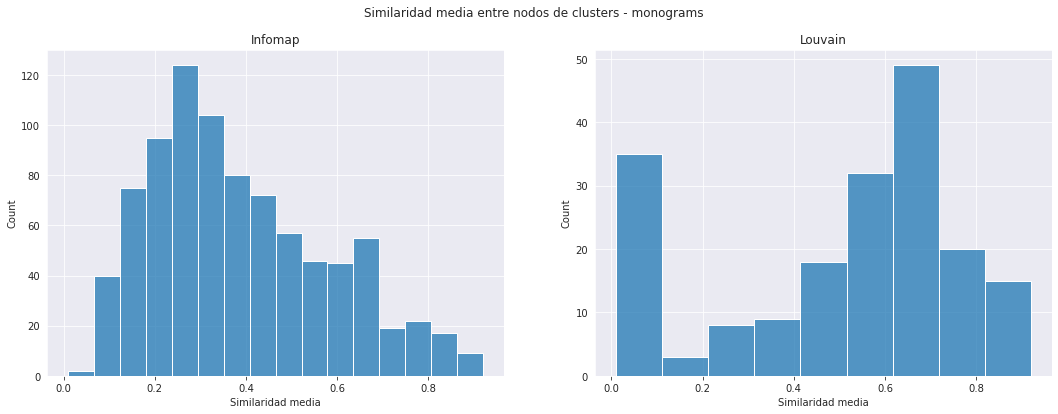

In [28]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Similaridad media entre nodos de clusters - monograms")
# ticks = np.logspace(0,tamaños_infomap.max(),10)

sns.histplot(data=infomap_clusters.mean_similarity_tfidf_extended, ax=ax[0])
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters.mean_similarity_tfidf_extended, ax=ax[1])
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

Voy a hacer un barrido de hiperparámetros para la similaridad nodo a nodo.

Los parámetros son:

min_df :  ignorar términos que aparecen en menos de "min_df" documentos, ya sea porcentaje o número absoluto
max_df :  idem, pero ignora términos que aparecen en más de "max_df" documentos, por porcentaje o número absoluto
max_features: el largo máximo del vector de features que obtengo
ngram_range: si quiero monogramas, bigramas, etc y si quiero una mezcla o solo un tipo

Para juzgar el resultado voy a ver la similaridad media por cluster y la distribución de max score para cada enfermedad

In [150]:
tfidf_similarity_search = []

min_df_values = [1,2]
max_df_values = [0.3,0.5]
max_features = [1000,3000,8000]
ngram_ranges = [(1,1),(2,2),(3,3),(1,2),(1,3)]

for min in min_df_values:
    for max in max_df_values:
        for max_feat in max_features:
            for n in ngram_ranges:
                vectorizer = TfidfVectorizer(tokenizer = lambda document: document.split() , stop_words=stop_words, ngram_range=n, min_df=min,max_df=max,max_features=max_feat)
                similarity_matrix = tfidf_similarity(vectorizer,corpus,ids)
                median_infomap = np.median(np.array([mean_similarity(similarity_matrix, cluster, "comunidades_infomap") for cluster in infomap_clusters.index.values]))
                median_louvain = np.median(np.array([mean_similarity(similarity_matrix, cluster, "comunidades_louvain") for cluster in louvain_clusters.index.values]))
                results = {"ngram_range":n,"min_df":min, "max_df":max, "max_feat":max_feat, "median_infomap": median_infomap, "median_louvain":median_louvain}
                tfidf_similarity_search.append(results)

results = pd.DataFrame.from_dict(tfidf_similarity_search)

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [169]:
results

,ngram_range,min_df,max_df,max_feat,median_infomap,median_louvain
0,"(1, 1)",1.0,0.3,1000,0.350,0.53
1,"(2, 2)",1.0,0.3,1000,0.190,0.25
2,"(3, 3)",1.0,0.3,1000,0.065,0.02
3,"(1, 2)",1.0,0.3,1000,0.350,0.53
4,"(1, 3)",1.0,0.3,1000,0.350,0.53
...,...,...,...,...,...,...
56,"(2, 2)",2.0,0.5,8000,0.225,0.44
57,"(3, 3)",2.0,0.5,8000,0.130,0.24
58,"(1, 2)",2.0,0.5,8000,0.330,0.55
59,"(1, 3)",2.0,0.5,8000,0.330,0.55


In [178]:
results.loc[results.median_louvain.idxmax()]

ngram_range       (1, 1)
min_df               1.0
max_df               0.3
max_feat            8000
median_infomap      0.35
median_louvain      0.59
Name: 10, dtype: object

In [179]:
results.loc[results.median_infomap.idxmax()]

ngram_range       (1, 1)
min_df               1.0
max_df               0.3
max_feat            3000
median_infomap      0.36
median_louvain      0.55
Name: 5, dtype: object

## Análisis por comunidades

Me pareció que no gané mucho haciendo el analisis de cluster con el vocabulario extendido. La entropía de los clusters aumenta, las descripciones que obtengo no me resultan tan informativas como las que obtenía antes, los scores máximos de términos por cada cluster también bajan.

Quizás como "descripción de cluster" está bien usar solo los títulos.

In [72]:
def cluster_as_document(cluster_id, cluster_algorithm):
    cluster_nodes = graph_node_data.loc[graph_node_data[cluster_algorithm] == cluster_id, "node_idx"].values
    cluster_corpus = [node_as_document(node_idx) for node_idx in cluster_nodes]
    cluster_document = " ".join(cluster_corpus)
    return cluster_document

In [116]:
infomap_ids = pd.unique(graph_node_data.loc[~graph_node_data.comunidades_infomap.isna(),"comunidades_infomap"])
louvain_ids = pd.unique(graph_node_data.loc[~graph_node_data.comunidades_louvain.isna(),"comunidades_louvain"])

corpus_infomap = [cluster_as_document(cluster_id,"comunidades_infomap") for cluster_id in infomap_ids]
corpus_louvain = [cluster_as_document(cluster_id,"comunidades_louvain") for cluster_id in louvain_ids]

args = {"min_df":3, "max_df":0.3, "max_features":5000}
vectorizers = [TfidfVectorizer(tokenizer = lambda document: document.split() , stop_words=stop_words, ngram_range=ngram_range, min_df=args["min_df"],max_df=args["max_df"],max_features=args["max_features"])for ngram_range in [(1,1),(2,2),(3,3),(1,3)]]

tfidf_infomap = []
tfidf_louvain = []

for i,vectorizer in enumerate(vectorizers):
    tfidf_infomap.append(get_tfidf_df(vectorizer, corpus_infomap,infomap_ids))
    tfidf_louvain.append(get_tfidf_df(vectorizer,corpus_louvain,louvain_ids))


In [76]:
tfidf_infomap

,.the,0,0.5,000,1,10,100,10mm,10q23,11,...,zinc,zlotogora,zollinger,zone,zones,zoonosis,zoonotic,zoster,zygomatic,–
0.0,0.000000,0.0,0.0,0.0,0.020822,0.0,0.0,0.0,0.0,0.000000,...,0.087957,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
59.0,0.000000,0.0,0.0,0.0,0.013255,0.0,0.0,0.0,0.0,0.044698,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
65.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
80.0,0.031984,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
48.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.019744,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
494.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
767.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.120099,0.120099,0.0,0.0,0.0
848.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [78]:
ejemplo = 421
cluster_as_document(ejemplo,"comunidades_infomap")

'peutz jeghers syndrome peutz jeghers syndrome  pjs  is an inherited gastrointestinal disorder characterized by development of characteristic hamartomatous polyps throughout the gastrointestinal  gi  tract  and by mucocutaneous pigmentation pjs carries a considerably increased risk of gi and extra gi malignancies a hereditary disease caused by autosomal dominant mutations involving chromosome 19 it is characterized by the presence of intestinal polyps  consistently in the jejunum  and mucocutaneous pigmentation with melanin spots of the lips  buccal mucosa  and digits a genetic intestinal polyposis syndrome characterized by development of characteristic hamartomatous polyps throughout the gastrointestinal  gi  tract  and by mucocutaneous pigmentation this disorder carries a considerably increased risk of gi and extra gi malignancies  bannayan riley ruvalcaba syndrome bannayan riley ruvalcaba syndrome  brrs  is a rare congenital disorder characterized by hamartomatous intestinal polypos

In [117]:
for df in tfidf_infomap:
    fig = px.bar(df.sparse.to_dense().loc[ejemplo].sort_values(ascending=False)[0:10])
    fig.show()

In [96]:
import scipy.stats
from scipy.stats import entropy
def get_entropy(series,normalized=True):
    """Calcula la entropía para una columna de valores de pandas. 
    La extrae como un array y la normaliza para que la suma sea 1 y después calcula la entropía.
    La normalizo por la entropía máxima posible, que sería la distribución uniforme pi=1/(b-a) para valores entre b y a. 
    En este caso es simplemente 1/ el largo del array"""
    values = series.values
    arr = values/(np.sum(values))
    max_entropy = entropy(np.ones(len(arr))/len(arr), base=2)
    if normalized:
        S = round(entropy(arr, base=2)/max_entropy,2)
    else:
        S = round(entropy(arr, base=2))
    return S

N=0:
S big cluster = 0.82, S small cluster = 0.5


N=1:
S big cluster = 0.74, S small cluster = 0.44


N=2:
S big cluster = 0.66, S small cluster = 0.39


N=3:
S big cluster = 0.83, S small cluster = 0.52




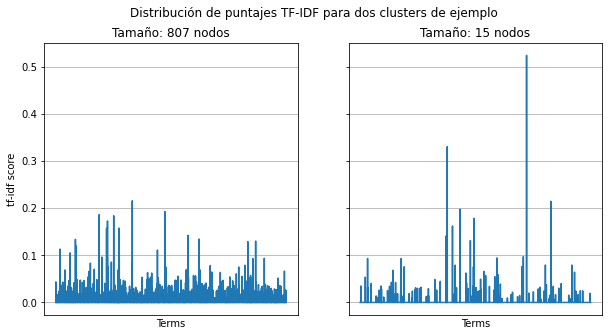

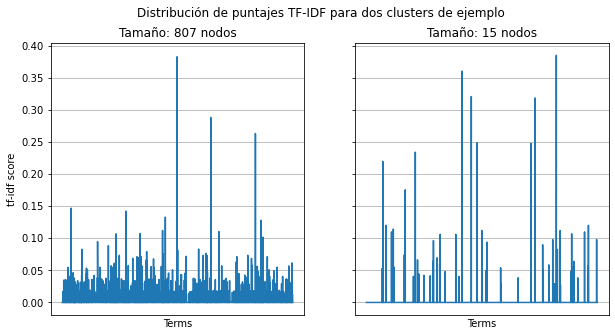

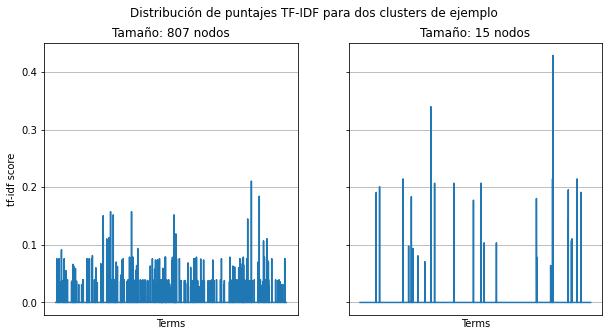

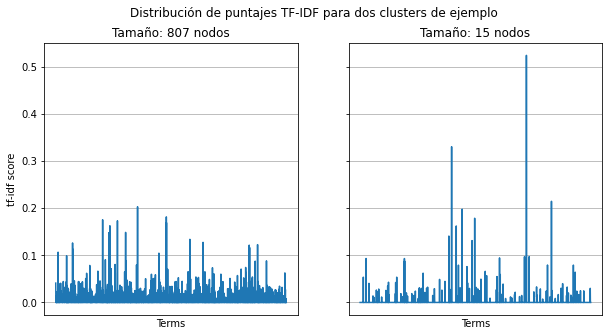

In [109]:
big_cluster = 116
small_cluster = 421

for n in range(4):
    fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
    fig.suptitle("Distribución de puntajes TF-IDF para dos clusters de ejemplo")

    ax[0].set_xticks([])
    ax[0].set_title(f"Tamaño: {tamaños_infomap.loc[big_cluster]} nodos")

    ax[1].set_xticks([])
    ax[1].set_title(f"Tamaño: {tamaños_infomap.loc[small_cluster]} nodos")

    tfidf_infomap[n].sparse.to_dense().loc[big_cluster].plot(ax=ax[0], xlabel='Terms', ylabel='tf-idf score')
    tfidf_infomap[n].sparse.to_dense().loc[ejemplo].plot(ax=ax[1], xlabel='Terms')

    ax[0].grid(True)
    ax[1].grid(True)

    print(f"N={n}:\nS big cluster = {get_entropy(tfidf_infomap[n].sparse.to_dense().loc[big_cluster])}, S small cluster = {get_entropy(tfidf_infomap[n].sparse.to_dense().loc[small_cluster])}\n\n")

Text(0, 0.5, 'Entropía')

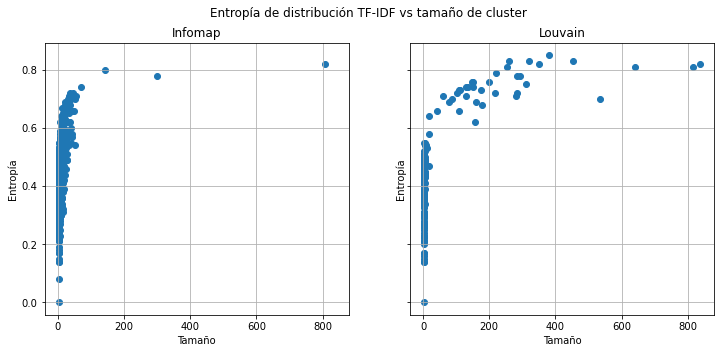

In [111]:
entropias_infomap = [get_entropy(tfidf_infomap[0].sparse.to_dense().loc[cluster]) for cluster in tamaños_infomap.index]
entropias_louvain = [get_entropy(tfidf_louvain[0].sparse.to_dense().loc[cluster]) for cluster in tamaños_louvain.index]

fig, ax = plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster")
ax[0].scatter(tamaños_infomap.values,entropias_infomap)
ax[0].set_title("Infomap")
ax[0].grid(True)
ax[0].set_xlabel("Tamaño")
ax[0].set_ylabel("Entropía")

ax[1].scatter(tamaños_louvain.values,entropias_louvain)
ax[1].set_title("Louvain")
ax[1].grid(True)
ax[1].set_xlabel("Tamaño")
ax[1].set_ylabel("Entropía")

poner en escala log y hacer control al azar para distintos tamaños de clusters, para trazar una curva. Repetir 100 veces, para tener barrita de error (tomo la media de esas 100 iteraciones)

In [112]:
def top_ngrams(monogram_matrix,bigram_matrix,trigram_matrix,clusters):
    all_stats = {}
    for cluster in clusters:
        stats = {}
        stats["top_monogram"] = monogram_matrix.loc[cluster].idxmax()
        stats["top_monogram_score"] = round(monogram_matrix.loc[cluster].max(),2)
        stats["top_bigram"] = bigram_matrix.loc[cluster].idxmax()
        stats["top_bigram_score"] = round(bigram_matrix.loc[cluster].max(),2)
        stats["top_trigram"] = trigram_matrix.loc[cluster].idxmax()
        stats["top_trigram_score"] = round(trigram_matrix.loc[cluster].max(),2)
        all_stats[cluster] = stats
    return all_stats

In [118]:
monograms_infomap = {cluster:tfidf_infomap[0].sparse.to_dense().loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}
monograms_louvain = {cluster:tfidf_louvain[0].sparse.to_dense().loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}

bigrams_infomap = {cluster:tfidf_infomap[1].sparse.to_dense().loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}
bigrams_louvain = {cluster:tfidf_louvain[1].sparse.to_dense().loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}

S_infomap = pd.Series({cluster:S for (cluster,S) in zip(tamaños_infomap.index.values, entropias_infomap)}, name="entropia")
S_louvain = pd.Series({cluster:S for (cluster,S) in zip(tamaños_louvain.index.values, entropias_louvain)}, name="entropia")

infomap_clusters = pd.concat([tamaños_infomap, S_infomap, pd.Series(monograms_infomap, name="top_5_monograms"),pd.Series(bigrams_infomap, name="top_5_bigrams")], axis=1)
louvain_clusters = pd.concat([tamaños_louvain, S_louvain, pd.Series(monograms_louvain, name="top_5_monograms"),pd.Series(bigrams_louvain, name="top_5_bigrams")], axis=1)

infomap_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_infomap[0].sparse.to_dense(),tfidf_infomap[1].sparse.to_dense(),tfidf_infomap[2].sparse.to_dense(),tamaños_infomap.index.values), orient="index")
louvain_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_louvain[0].sparse.to_dense(),tfidf_louvain[1].sparse.to_dense(),tfidf_louvain[2].sparse.to_dense(),tamaños_louvain.index.values), orient="index")

infomap_clusters = pd.merge(infomap_clusters, infomap_top_ngrams, how="inner",left_index=True, right_index=True)
louvain_clusters = pd.merge(louvain_clusters, louvain_top_ngrams, how="inner", left_index=True, right_index=True)

In [119]:
display(infomap_clusters.head())
display(louvain_clusters.head())

,tamaño,entropia,top_5_monograms,top_5_bigrams,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score
116.0,807,0.82,"[intellectual, disability, deficiency, dysplas...","[intellectual disability, short stature, agang...",intellectual,0.20,intellectual disability,0.42,short stature intellectual,0.24
37.0,301,0.78,"[intellectual, disability, anomalies, facial, ...","[intellectual disability, intellectual deficit...",intellectual,0.45,intellectual disability,0.59,intellectual disability characterized,0.28
117.0,143,0.80,"[pituitary, stalk, abnormalities, attacks, fra...","[cavernous sinus, fragile site, eye movements,...",pituitary,0.37,cavernous sinus,0.21,autosomal recessive inheritance,0.21
64.0,69,0.74,"[cleft, palate, anomalies, short, lip]","[cleft palate, cleft lip, lip palate, robin se...",cleft,0.48,cleft palate,0.54,cleft lip palate,0.47
28.0,54,0.71,"[optic, atrophy, neurodegenerative, progressiv...","[optic atrophy, intellectual disability, autos...",optic,0.35,optic atrophy,0.45,rare genetic neurodegenerative,0.21


,tamaño,entropia,top_5_monograms,top_5_bigrams,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score
26.0,838,0.82,"[intellectual, deficiency, disability, defect,...","[intellectual disability, septal defect, short...",intellectual,0.21,intellectual disability,0.39,ventricular septal defect,0.47
2.0,816,0.81,"[intellectual, disability, anomalies, delay, f...","[intellectual disability, developmental delay,...",intellectual,0.38,intellectual disability,0.52,intellectual disability characterized,0.21
1.0,640,0.81,"[deficiency, mitochondrial, progressive, seizu...","[autosomal recessive, metabolism characterized...",deficiency,0.29,autosomal recessive,0.29,global developmental delay,0.24
33.0,533,0.70,"[carcinoma, adenocarcinoma, cells, cell, malig...","[cell carcinoma, squamous cell, characterized ...",carcinoma,0.63,cell carcinoma,0.41,squamous cell carcinoma,0.55
16.0,453,0.83,"[dysplasia, anomalies, cleft, palate, hypoplasia]","[cleft palate, short stature, rare genetic, de...",dysplasia,0.27,cleft palate,0.29,cleft lip palate,0.39


In [120]:
def regiones_entropia(df,cortes,nsamples):
    region1 = df[df.entropia <= cortes[0]].sample(nsamples)
    region2 = df[(df.entropia > cortes[0]) & (df.entropia <= cortes[1])].sample(nsamples)
    region3 = df[df.entropia > cortes[1]].sample(nsamples)
    return [region1,region2,region3]

In [121]:
ejemplos_infomap = regiones_entropia(infomap_clusters, (0.4,0.6), 3)
ejemplos_louvain = regiones_entropia(louvain_clusters,(0.4,0.6), 3)

In [122]:
ejemplos_infomap[1]

,tamaño,entropia,top_5_monograms,top_5_bigrams,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score
275.0,7,0.45,"[prostate, carcinoma, prostatic, intraepitheli...","[prostate carcinoma, prostate gland, infectiou...",prostate,0.81,prostate carcinoma,0.77,carcinoma developed relatives,0.39
294.0,20,0.53,"[papillary, papilloma, papillomatosis, epithel...","[papillary epithelial, epithelial neoplasm, pa...",papillary,0.48,papillary epithelial,0.35,papillary epithelial neoplasm,0.40
182.0,12,0.57,"[streptococcus, streptococcal, shock, pyogenes...","[streptococcus pyogenes, streptococcus pneumon...",streptococcus,0.47,streptococcus pyogenes,0.41,characterized high fever,0.54


In [127]:
ejemplo = ejemplos_infomap[1].sample(1).index[0]
cluster_as_document(ejemplo,"comunidades_infomap")

'pneumococcal infections infections with bacteria of the species streptococcus pneumoniae infections with bacteria of the species streptococcus pneumoniae  streptococcal pneumonia a febrile disease caused by streptococcus pneumoniae a febrile disease caused by streptococcus pneumoniae  toxic shock syndrome a rare acute life threatening systemic bacterial noncontagious illness caused by exotoxins from bacteria of either the streptococcus pyogenes or staphylococcus aureus type it is characterized by high fever  hypotension  rash  multi organ dysfunction  and cutaneous desquamation during the early convalescent period the toxins affect the host immune system  causing an exuberant and pathological host inflammatory response laboratory findings include leukocytosis  elevated prothrombin time  hypoalbuminemia  hypocalcemia  and pyuria syndrome characterized by high fever  vomiting  diarrhea  confusion  and skin rash  almost all cases have been related to an infection with toxin producing sta

In [270]:
for df in tfidf_infomap:
    fig = px.bar(df.sparse.to_dense().loc[421].sort_values(ascending=False)[0:10])
    fig.show()